In [1]:
import sys
import os
import distutils.core
import torch
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import json
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import cv2 

/home/neru/M5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
#load dataset
annotations_path = "./annotations/instances_val2017.json"
database_path = "./val2017/"
coco_annotation=COCO(annotations_path)
 
 

loading annotations into memory...
Done (t=1.19s)
creating index...
index created!


In [4]:
def load_random_image(annotations, database_path):

    random_img_filename = random.choice(os.listdir(database_path)) #change dir and pick random image
    random_img = cv2.imread(database_path+random_img_filename)  #read image
    random_img_id = int(random_img_filename.split('.')[0])  #get id

    random_annotation_ids = annotations.getAnnIds(imgIds=random_img_id)   #get annotations (list of all gt detections in image)
    random_annotation_id = random_annotation_ids[random.randint(0, len(random_annotation_ids)-1)]   #pick 1
    random_annotation_img  = annotations.loadAnns(random_annotation_id)
    random_mask= annotations.annToMask(random_annotation_img[0])
    
    print("Random image filename: ",random_img_filename)
    print("Random image annotations" ,random_annotation_img)
    return random_img, random_mask

def load_image_and_annotations(img_filename, database_path):
    img = cv2.imread(database_path+img_filename)
    img_id = int(img1_filename.split('.')[0])
    info = coco_annotation.loadImgs([img_id])
    return img, info




Random image filename:  000000368038.jpg
Random image annotations [{'segmentation': [[73.37, 118.96, 99.02, 111.13, 141.76, 106.85, 139.62, 101.87, 205.87, 98.31, 208.01, 84.77, 237.93, 71.95, 290.64, 79.78, 299.9, 90.47, 309.16, 78.36, 304.18, 56.28, 331.25, 46.3, 361.17, 39.89, 413.88, 37.76, 427.42, 33.48, 429.55, 29.21, 465.88, 26.36, 482.98, 49.87, 536.41, 38.47, 548.52, 32.77, 558.49, 40.6, 576.3, 21.37, 579.86, 17.1, 579.86, 37.04, 591.26, 34.91, 596.96, 20.66, 619.04, 19.95, 629.01, 29.21, 633.29, 300.62, 143.9, 180.94, 84.06, 162.42, 71.95, 143.18, 70.52, 134.64]], 'area': 95325.90145, 'iscrowd': 0, 'image_id': 368038, 'bbox': [70.52, 17.1, 562.77, 283.52], 'category_id': 7, 'id': 172092}]
Target image:  000000154000.jpg


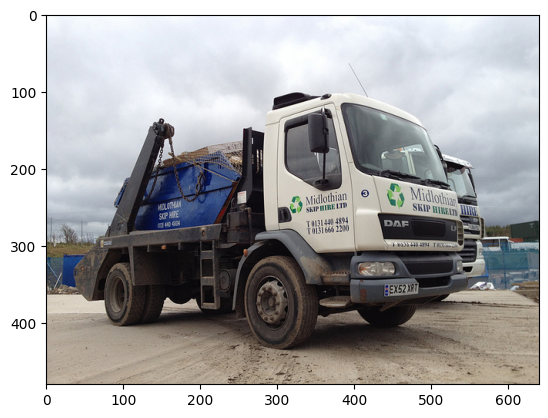

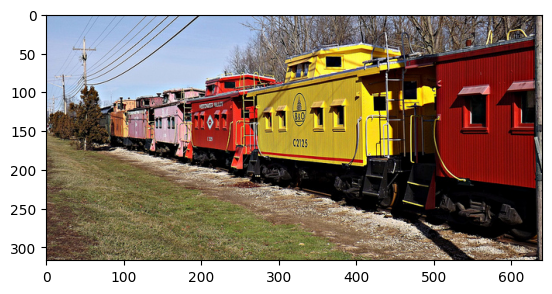

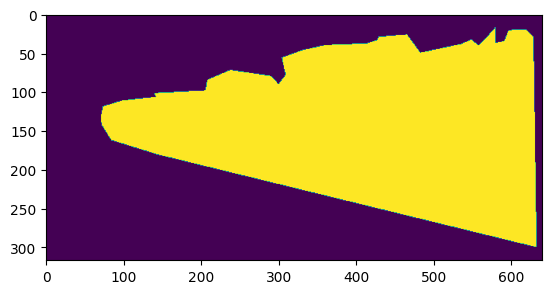

In [5]:
#load main image
img1_filename = random.choice(os.listdir(database_path)) #pick randomly or select a filename
img1, info_img1 = load_image_and_annotations(img1_filename, database_path)
img1_h, img1_w, img1_chann = img1.shape

#load random image
img2, random_mask_img2 = load_random_image(coco_annotation, database_path)

plt.figure()
plt.imshow(img1[:,:,::-1])
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.figure()
plt.imshow(random_mask_img2)

print("Target image: ",img1_filename)

im = img1.copy()


In [6]:
def pad_image(img, new_image_height, new_image_width):
    
    color = (0,0,0)
    if len(img.shape)==3:
        old_image_height, old_image_width, channels = img.shape
        
        result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)
    if len(img.shape)==2:
        old_image_height, old_image_width = img.shape
        result = np.full((new_image_height,new_image_width), 0, dtype=np.uint8)



    print("NEW " ,new_image_height, "W ", new_image_width)
    print("OLD " ,old_image_height, "W ", old_image_height)
    if old_image_height>new_image_height:
        img = img[round((old_image_height-new_image_height)/2):-round((old_image_height-new_image_height)/2),:]
        old_image_height = new_image_height
    if old_image_width>new_image_width:
        img = img[:,round((old_image_width-new_image_width)/2):-round((old_image_width-new_image_width)/2)]
        old_image_width = new_image_width
    
    print("OLD AFREW " ,img.shape[0], "W ", img.shape[1])
    
    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
        x_center:x_center+old_image_width] = img

    return result
def transplant_images(image_1, image_2,image_2_mask):

    image_1_copy = image_1.copy() 

    #--- Copy pixel values of logo image to room image wherever the mask is white ---
    image_1_copy[np.where(image_2_mask == 1)] = image_2[np.where(image_2_mask == 1)]

    return image_1_copy

def apply_transformation(img, tx,ty, angle):
    
    # Rotate the image using cv2.warpAffine()
    M = cv2.getRotationMatrix2D((ty, tx), angle, 1)
    warped_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return warped_img



NEW  480 W  640
OLD  317 W  317
OLD AFREW  317 W  640
NEW  480 W  640
OLD  317 W  317
OLD AFREW  317 W  640


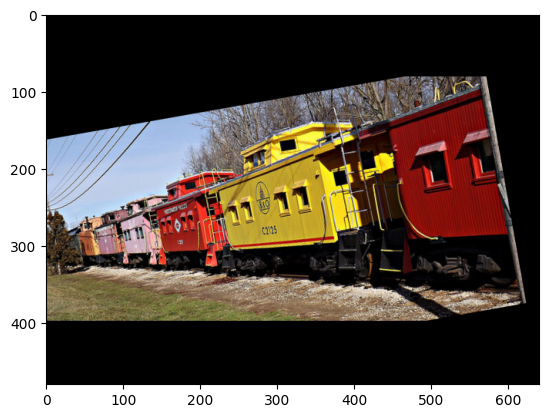

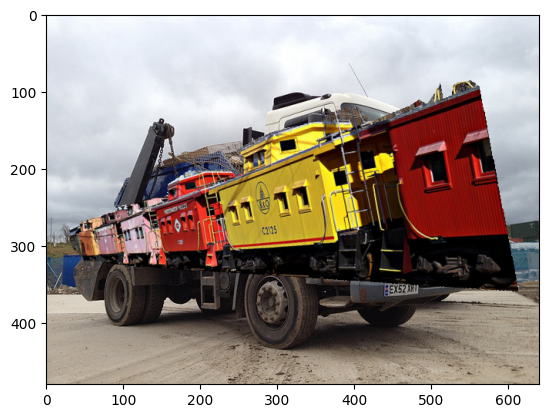

In [7]:
tx =400
ty = 500
rotation_angle_deg = 10
warped_image = apply_transformation(img2,tx, ty,rotation_angle_deg)
warped_mask =  apply_transformation(random_mask_img2,tx, ty,rotation_angle_deg)

warped_image =  pad_image(warped_image,img1_h, img1_w)
warped_mask =  pad_image(warped_mask,img1_h, img1_w)

plt.figure()
plt.imshow(warped_image[:,:,::-1])
new_image =  transplant_images(img1, warped_image,warped_mask)

plt.figure()
plt.imshow(new_image[:,:,::-1])


In [8]:
cfg = get_cfg()
model = 'mask_rcnn'
if model == 'mask_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
elif model == 'fast_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

[03/23 23:22:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [9]:
def predict(predictor, img):
    outputs = predictor(img)
    output_predictions = outputs["instances"].pred_classes
    print(output_predictions)
    print(outputs["instances"].pred_boxes)

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_image= out.get_image()
    return output_image, output_predictions

tensor([7])
Boxes(tensor([[ 31.4773,  93.3104, 568.3848, 428.9454]]))
tensor([7, 6])
Boxes(tensor([[ 19.7971,  80.0015, 619.3990, 431.2406],
        [ 17.4484,  84.3994, 624.2918, 419.2422]]))


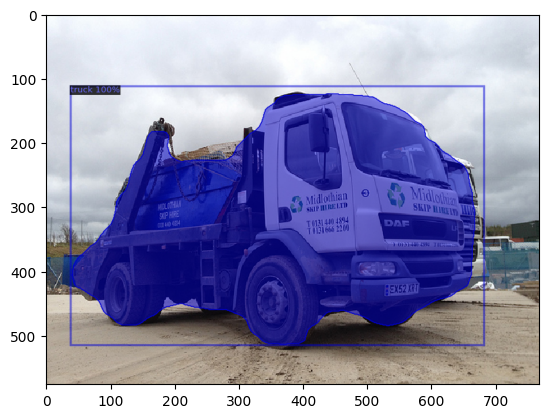

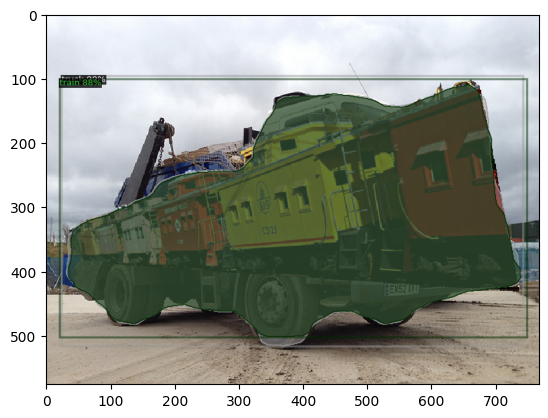

In [10]:

output_image_1, _ = predict(predictor, img1)
plt.figure()
plt.imshow(output_image_1)
output_new_image, _ = predict(predictor,new_image)
plt.figure()
plt.imshow(output_new_image)

In [11]:
#get all ids
image_ids = coco_annotation.getImgIds()

# get categories
category_ids = coco_annotation.getCatIds()
num_category_ids = len(category_ids)

# initialize co-occurrence matrix
coocurrence_matrix = np.zeros([91,91])

# for each image in our database
for image_id in image_ids:
    # load annotations
    annotations = coco_annotation.loadAnns(coco_annotation.getAnnIds(imgIds=image_id))

    # extract IDs for the annotations
    annotation_category_ids = [annotation['category_id'] for annotation in annotations]
    
    # increment co-occurrence if theyre both in the same image
    for category_id_i in category_ids:
        for category_id_j in category_ids:
            if category_id_i in annotation_category_ids and category_id_j in annotation_category_ids:
                coocurrence_matrix[category_id_i-1,category_id_j-1] = coocurrence_matrix[category_id_i-1,category_id_j-1] + 1
    

print(np.asarray(coocurrence_matrix[0]!= 0).nonzero())
print(np.sort(annotation_category_ids))
print(coocurrence_matrix[0])
print(len(category_ids))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 69, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89]),)
[ 1  1  1  1  1  1  1  1  1  1  1 47 51 63 77]
[2.693e+03 1.220e+02 3.590e+02 1.280e+02 3.100e+01 1.430e+02 7.700e+01
 1.590e+02 7.600e+01 1.130e+02 3.800e+01 0.000e+00 2.000e+01 1.300e+01
 1.650e+02 3.100e+01 2.300e+01 7.600e+01 8.900e+01 2.500e+01 2.400e+01
 3.400e+01 3.000e+00 2.000e+00 1.400e+01 0.000e+00 2.140e+02 1.460e+02
 0.000e+00 0.000e+00 2.810e+02 1.380e+02 7.600e+01 7.300e+01 1.200e+02
 4.800e+01 1.590e+02 8.200e+01 9.400e+01 9.900e+01 1.240e+02 1.420e+02
 1.660e+02 2.070e+02 0.000e+00 8.000e+01 2.170e+02 7.200e+01 9.900e+01
 7.400e+01 1.320e+02 4.000e+01 2.800e+01 3.800e+01 2.900e+01 7.000e+00
 1.900e+01 3.200e+01 9.100

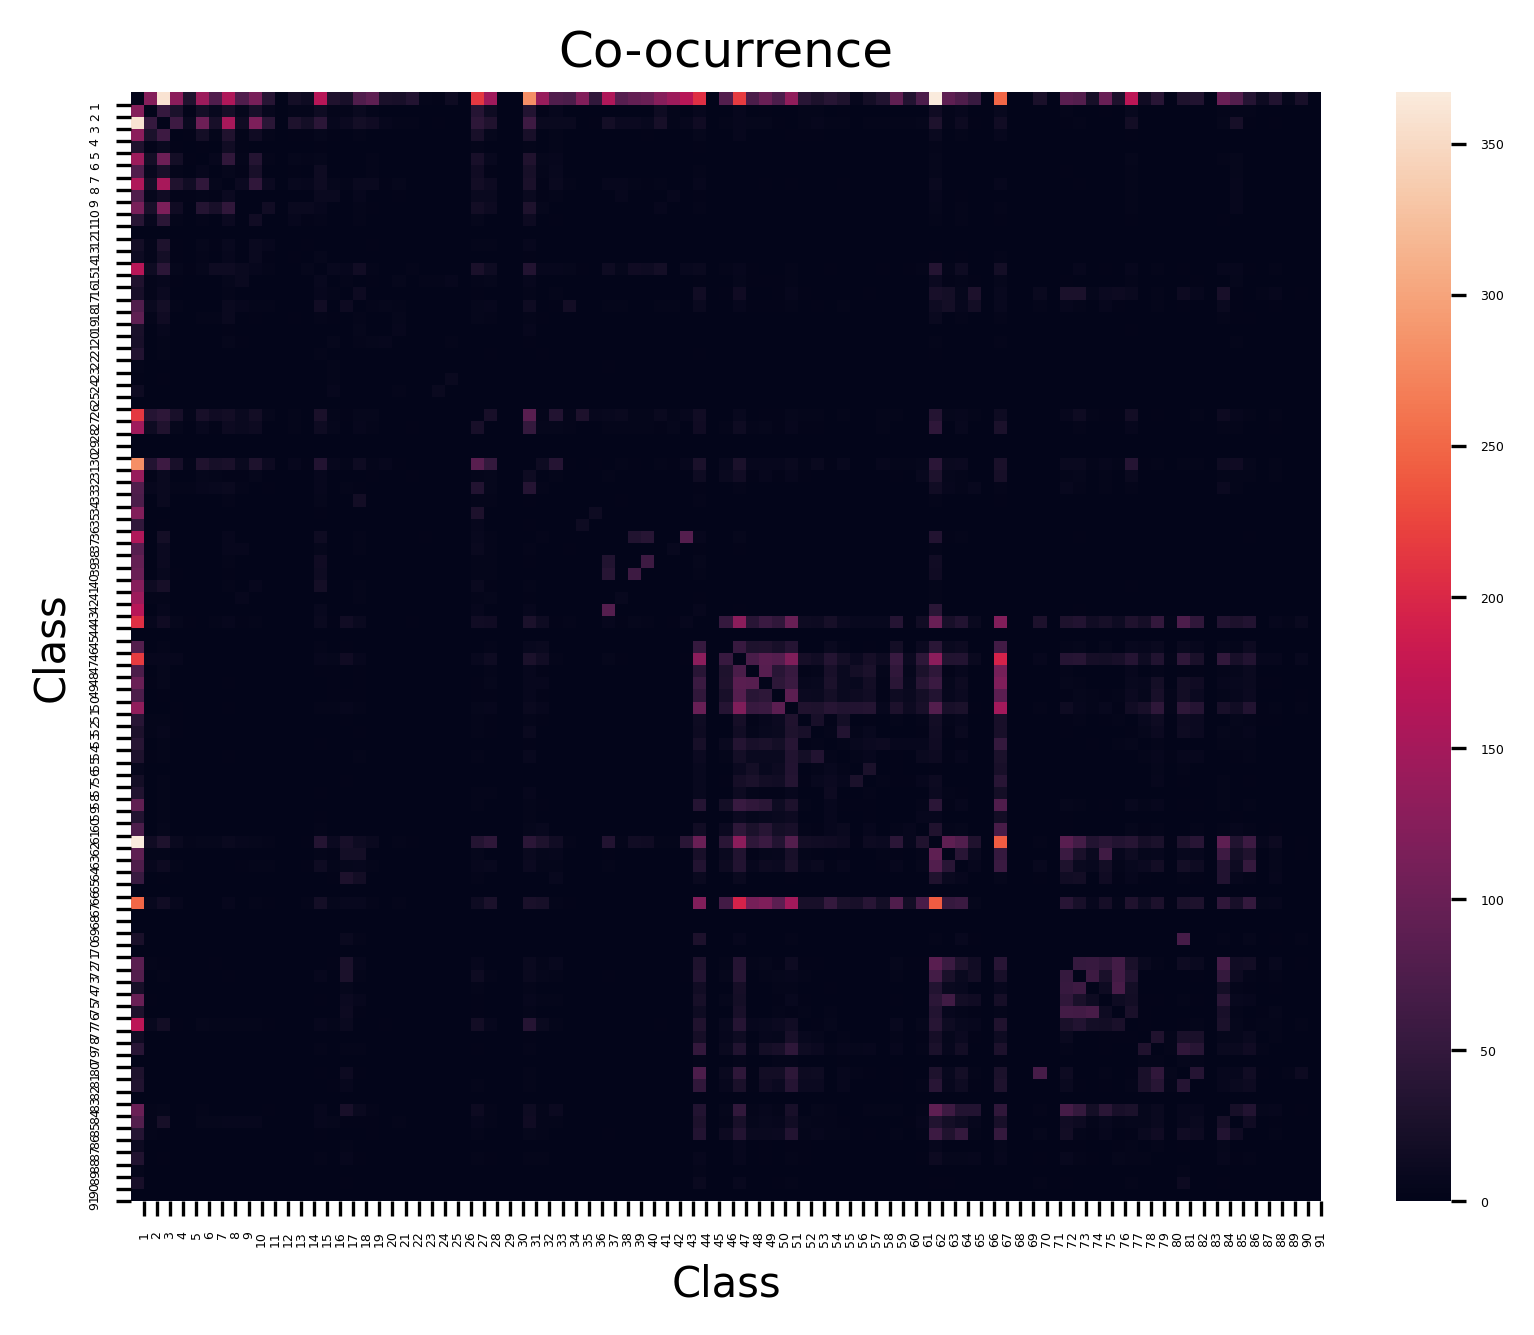

In [12]:
np.fill_diagonal(coocurrence_matrix, 0, wrap=False)
import seaborn as sns
import pandas as pd
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
mpl.rc('xtick', labelsize=3) 
mpl.rc('ytick', labelsize=3) 
sns.heatmap(coocurrence_matrix)

class_array = np.linspace(1, 91, num=91).astype(int)
# creating the dataframe
df = pd.DataFrame(data = coocurrence_matrix, 
                  index =class_array, 
                  columns = class_array)

plt.clf() # clear figure 
sns.heatmap(df).set(xlabel='Class',
       ylabel='Class',title='Co-ocurrence')
plt.xticks(class_array,class_array)
plt.yticks(class_array,class_array)
mpl.rcParams.update(mpl.rcParamsDefault)